# Time series EDA

In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data separation/transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# system manipulation
import itertools
import os
import sys
sys.path.append("./util_")
import prepare_
# import explore_

# other
import warnings
warnings.filterwarnings("ignore")

# set the random seed
np.random.seed(95)


# set a default them for all my visuals
sns.set_theme(style="whitegrid")

**Get data**

In [2]:
# load data from existing csv
train = pd.read_csv("./00_project_data/1-1_training_data.csv", index_col=0)
train.head()

,bite,year,month,day,month_number,weekday_number
dateofbite,,,,,,
2015-01-01,7,2015,January,Thursday,1,3
2015-01-02,9,2015,January,Friday,1,4
2015-01-03,7,2015,January,Saturday,1,5
2015-01-04,11,2015,January,Sunday,1,6
2015-01-05,5,2015,January,Monday,1,0


In [3]:
# make sure the index in in time format
train.index = train.index.astype("datetime64")

**Temporal Trends: Are there any noticeable trends in the number of dog bites over time?**

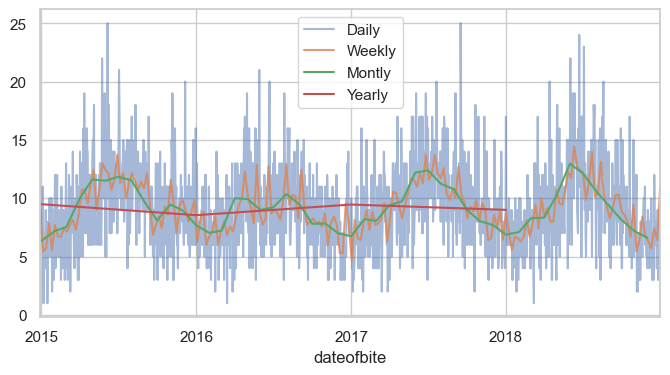

In [53]:
plt.figure(figsize=(8,4))
train.bite.resample('D').mean().plot(alpha=.5, label='Daily')
train.bite.resample('W').mean().plot(alpha=.8, label='Weekly')
train.bite.resample('M').mean().plot(label='Montly')
train.bite.resample('Y').mean().plot(label='Yearly')
plt.legend()

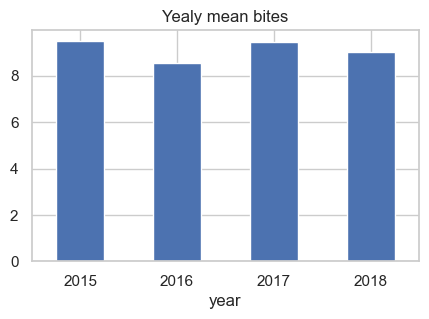

In [54]:
# Yearly mean bits
plt.figure(figsize=(5,3))
train.groupby("year").bite.mean().plot(kind="bar")
plt.title("Yealy mean bites")
plt.xticks(rotation=0)
plt.show()

- About constant level trend over time witha yearly seasonality to the data.

**Seasonal Patterns: Do dog bites exhibit seasonal patterns? Are certain months or seasons associated with a higher number of incidents?**

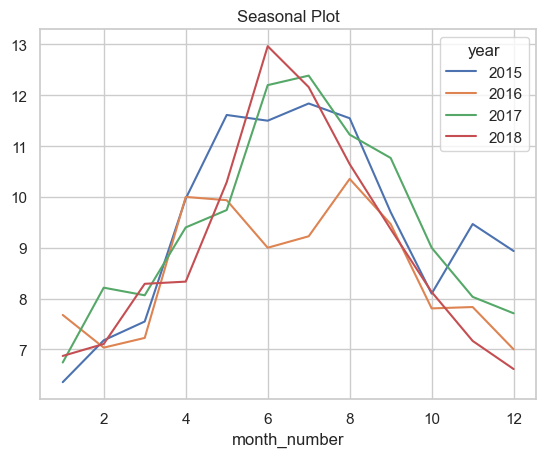

In [52]:
# .unstack turns an index level into columns
train.groupby(["year","month_number"]).bite.mean().unstack(0).plot(title='Seasonal Plot')
plt.show()

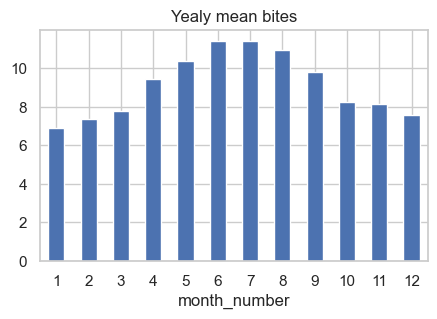

In [58]:
# Yearly mean bits
plt.figure(figsize=(5,3))
train.groupby("month_number").bite.mean().plot(kind="bar")
plt.title("Yealy mean bites")
plt.xticks(rotation=0)
plt.show()

- zThere is a clear seasonal patten between years
- June and July are with the highers bite average over all.
- There is a large difference in bites between 2016 and 2018 that is not shown in 2017. (Looking at month of June and July)


**Day of the Week: Are there specific days of the week when dog bites are more frequent than others? Do weekends or weekdays show different patterns?**

Monthly and Daily Variations: Are there variations in the number of dog bites across different months and days of the month?

Yearly Comparisons: How do the number of dog bites in different years compare? Are there any significant changes year over year?

Outliers: Are there any outlier days or months with exceptionally high or low numbers of dog bites? Can you identify any potential reasons for these outliers?

Correlations: Are there any correlations between the number of dog bites and other factors such as breed, age, gender, spay/neuter status, or location (borough or zipcode)?

Day-to-Day Variability: How much does the number of dog bites vary from one day to the next? Is there any evidence of autocorrelation, where the number of bites on one day is related to the number on the previous day?

Holiday and Event Influence: Are there any noticeable effects of holidays or special events on the number of dog bites?

Long-Term Seasonality: Apart from annual seasonality, are there any longer-term seasonal patterns that repeat over several years?

**Take aways**

Temporal Trends:
- About constant level trend over time witha yearly seasonality to the data.

Seasonal Patterns:
- zThere is a clear seasonal patten between years
- June and July are with the highers bite average over all.
- There is a large difference in bites between 2016 and 2018 that is not shown in 2017. (Looking at month of June and July)

Day of the Week:
